# Community Detection

Community Detection is an unsupervised task, where no label information can be used to train a graph neural network. Its ultimate objective is to group (cluster) nodes into groups. A natural way to do community detection is to learn node embeddings in an unsupervised manner and then perform clustering algorithms on the node embeddings.

<hr/>

### Node Embedding Algorithms
##### Doesn't require node features
- Adjacency matrix
- Node2Vec
- Watch your step

##### Requires node features
- Cosine distance matrix
- Deep Graph Infomax (DGI) - extracts self information of graph as well as each node representation and then maximize the mutual information between graph representation and node representations.
- Attr2vec - learns node representations by performing a linear/non-linear mapping on node content attributes.
- Unsupervised GraphSAGE - given a large set of "positive" node pairs generated from random walks performed on the graph, and an equally large set of "negative" node pairs that are randomly selected from the graph according to a certain distrubution, learn a binary classifier that predicts whether arbitrary node pairs are likely to co-occur in a random walk. Through learning this simple binary node-pair-classification task, the model automatically learns an inductive mapping from attirubtes of nodes and their neighbors to node embeddings in a high-dimensional vector space.


### Clustering Algorithms
##### Common ML clustering algorithms to use from sklearn
- K-means
- Hierarchical clustering, a.k.a. Agglomerative Clustering
- DBSCAN

### Combined Algorithms
- Fast Greedy
- Infomap
- Label Propagation
- Leading eigenvector
- Leiden
- Multilevel (Louvain)
- Walktrap

### Future algorithm consideration
- Modularity maximization
- CommDGI
- Gaussian Mixture Clustering
- Optimal Modularity

### Algorithms out of scope and its reason
- Edge betweenness - too slow
- Leading eigenvector_naive - doesn't support?
- Optimal Modularity - igraph error
- Spinglass - doesn't work with disconnected graphs
- GraphWave - Not practical

##### Resources:
- Clustering Algorithms in sklearn: https://scikit-learn.org/stable/modules/clustering.html

In [5]:
### IMPORTING the script files
import sys
sys.path.insert(1, '../')
from models import util_data, util_graph, util_model

# General package needs
import random
import itertools
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore') # supress warnings due to some future deprications

# Graph-related package
import networkx as nx
import igraph as ig
import stellargraph as sg
from stellargraph import StellarGraph, globalvar
from networkx.linalg.graphmatrix import adjacency_matrix

# Visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from matplotlib.pyplot import figure
%matplotlib inline

In [6]:
### ML/AI specific

# ML/AI Workflow
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph.utils import plot_history

from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
    GraphSAGELinkGenerator,
)
from stellargraph.data import EdgeSplitter
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping

from stellargraph import datasets
from IPython.display import display, HTML

# ML/AI Algorithms / Components
from sklearn.mixture import GaussianMixture
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE
from stellargraph.layer import GraphSAGE
import tensorflow as tf
from tensorflow.keras import optimizers, Model, layers, regularizers
from tensorflow.keras.optimizers import Adam
# from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
random.seed(123)
tf.random.set_seed(1234)
# from stellargraph.core import StellarGraph

# Read Dataset

In [7]:
# Temporary read from opensea
# This data is not pushed to github due to its size
node_df = pd.read_csv("../../data/nodes.csv") 
edge_df = pd.read_csv("../../data/edges_withTotalPriceUSD.csv")
#node_df = node_df.append(pd.DataFrame(['nan'], columns = ['Id']))
edge_df = edge_df.dropna(subset=['SellerAddress', 'WinnerAddress']).reset_index()

In [8]:
edge_df.head()

index  Unnamed: 0                               WinnerAddress  \
0      0          18  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
1      1          23  0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7   
2      2          33   0xa4eafeb533d4111a1fe3a8b323c468976ac2323   
3      3          38  0xb9fddbd225b6c8cc24ce193e5fb95db76d783f2d   
4      4          43  0xe369a8d4e8799d381cd5734eafd812cfb5c2574a   

                                SellerAddress            Timestamp  \
0  0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7  2021-04-11T20:10:12   
1  0x0a4eafeb533d4111a1fe3a8b323c468976ac2323  2021-04-11T01:20:32   
2    0xd7c902fbbcd3c9db2da80a439c94486c50eb81  2017-07-10T14:03:38   
3  0xe369a8d4e8799d381cd5734eafd812cfb5c2574a  2021-02-15T08:50:46   
4  0xd93033ac253ce4320128666d999c392cfc09a523  2021-02-15T08:15:30   

    EventType PaymenTokenSymbol  TotalPrice  TokenId  \
0  successful               ETH       79.99     9159   
1  successful               ETH       56.50     9159   
2  successful               ETH        0.00     9159   
3  successful               ETH       10.00     9158   
4  successful               ETH        8.00     9158   

                         AssetContractAddress  ...  TransactionId  BidAmount  \
0  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb  ...    100167026.0        NaN   
1  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb  ...     99767950.0        NaN   
2  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb  ...       368886.0        NaN   
3  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb  ...     81978766.0        NaN   
4  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb  ...     81973239.0        NaN   

   AssetNumSales                           AssetOwnerAddress  \
0              3  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
1              3  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
2              3  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
3              2  0xb9fddbd225b6c8cc24ce193e5fb95db76d783f2d   
4              2  0xb9fddbd225b6c8cc24ce193e5fb95db76d783f2d   

  FromAccountAddress  UsedEthscan  \
0                NaN        False   
1                NaN        False   
2                NaN         True   
3                NaN        False   
4                NaN         True   

                                     TransactionHash        date  \
0  0xe4c985d1dadf4be3b1bca5dc4a4d44806c676c850cc0...  2021-04-11   
1  0x18fb2f51fc2d939e2936e86657ee4eeb6d73792b865c...  2021-04-11   
2  0x9c335e2621879e05a6c7e7948af58a671d9efae7e439...  2017-07-10   
3  0x2b67c566d72d2cd4091960a89eed1c2a9825f985aa53...  2021-02-15   
4  0x13c69a9e2178f2a3c445f3a382b8e103135a6d707021...  2021-02-15   

  eth_open_price  TotalPriceUSD  
0    2132.080000  170545.079200  
1    2132.080000  120462.520000  
2     205.760000       0.000000  
3    1806.922822   18069.228221  
4    1806.922822   14455.382577  

[5 rows x 21 columns]

# Step 1. Define Graph in Networkx Format

In [9]:
edge_df['TotalPriceUSD_reverse'] = edge_df['TotalPriceUSD'].apply(lambda p: 100000/p if p > 0 else 1000)
edge_df['TotalPriceUSD_reverse']

node_id_col = 'Id'
node_label_col = []
node_attr_cols = []

edge_id_col = ['index']
edge_src_col = 'SellerAddress'
edge_dst_col = 'WinnerAddress'
edge_attr_cols = ['TotalPriceUSD_reverse']

##### Networkx Graph Object

In [10]:
G_nx = util_graph.create_graph_nx(node_df, edge_df, 
                                  node_id_col=node_id_col, 
                                  edge_src_col=edge_src_col, edge_dst_col=edge_dst_col,
                                  node_attr_cols=node_attr_cols, edge_attr_cols=edge_attr_cols)
print(nx.info(G_nx))

MultiGraph with 5123 nodes and 14419 edges


The below codes converts networkx graph into StellarGraph and IGraph. 

**TODO** Determine which object is needed depending on algorithms to use

##### StellarGraph Object

**TODO** Build this in util_graph if needed

In [11]:
G_stellar = StellarGraph.from_networkx(G_nx)

##### Igraph Object

In [13]:
G_ig = util_graph.create_graph_ig(nx.to_numpy_matrix(G_nx), graph_type='undirected')
G_ig.summary()

'IGRAPH U--- 5123 14419 -- '

### Querying graph structures

In [14]:
print("# Nodes", G_nx.number_of_nodes())
print("# Edges", G_nx.number_of_edges())
print("Is this multigraph?", G_nx.is_multigraph())
print("The graph is disconnected into {} networks".format(nx.number_connected_components(G_nx)))

Gcc = sorted([G_nx.subgraph(c) for c in nx.connected_components(G_nx)], key=len, reverse=True)
cc_sizes = []
for cc in list(Gcc):
    cc_sizes.append(len(cc.nodes()))
print(cc_sizes)

# Nodes 5123
# Edges 14419
Is this multigraph? True
The graph is disconnected into 291 networks
[4736, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


The distribution of connected components' sizes shows that there is a single large component, and a few isolated groups.

We expect the community detection/node embedding clustering algorithms to discover non-trivial communities that are not simply the connected components of the graph.

# Step 2. Visualizing graph
This part is skipped (or not useful) as it will be done outside of this notebook in order to be more interactive.

In [15]:
# nx.draw(G_nx, node_size=20, alpha=0.3)

# Step 3. AI Experiment

In [17]:
model_options = []
# model_options.append('AdjMatrix_KMeans')
# model_options.append('AdjMatrix_Hierarchical') 
# model_options.append('AdjMatrix_DBSCAN') 
# model_options.append('Node2Vec_KMeans')
# model_options.append('Node2Vec_Hierarchical')
# model_options.append('Node2Vec_DBSCAN')
#                  ['WatchYourStep', 'KMeans'], 
#                  ['WatchYourStep', 'Hierarchical'], 
#                  ['WatchYourStep', 'DBSCAN'],
#                  ['FastGreedy'], 
#                  ['Infomap'], 
#                  ['LabelPropagation'], 
#                  ['LeadingEigenvector'], 
#                  ['Leiden'], 
#                  ['Multilevel'], 
#                  ['Walktrap']]

# model_options = [['AdjMatrix', 'CosineModularity']]

# # these options are possible when nodes have features
# model_options += [['CosineDist', 'KMeans'],
#                   ['CosineDist', 'Hierarchical'],
#                   ['CosineDist', 'DBSCAn'],
#                   ['CosineDist', 'GaussianMixture'],
#                   ['CosineDist', 'Modularity'],
#                   ['DGI', 'KMeans'],
#                   ['DGI', 'Hierarchical'],
#                   ['DGI', 'DBSCAn'],
#                   ['DGI', 'GaussianMixture'],
#                   ['DGI', 'Modularity'],
#                   ['Attri2Vec', 'KMeans'],
#                   ['Attri2Vec', 'Hierarchical'],
#                   ['Attri2Vec', 'DBSCAn'],
#                   ['Attri2Vec', 'GaussianMixture'],
#                   ['Attri2Vec', 'Modularity'],
#                   ['UnsupervisedGraphSAVE', 'KMeans'],
#                   ['UnsupervisedGraphSAVE', 'Hierarchical'],
#                   ['UnsupervisedGraphSAVE', 'DBSCAn'],
#                   ['UnsupervisedGraphSAVE', 'GaussianMixture'],
#                   ['UnsupervisedGraphSAVE', 'Modularity'],
#                  ]

n_clusters = range(5, 100, 20)
dist_thr = range(3, 10, 2)

eps=[0.3, 0.2]
min_samples = [3, 5]


# Node2Vec
walk_length = [5]
p = [0.5]  # defines probability, 1/p, of returning to source node
q = [2.0]  # defines probability, 1/q, for moving to a node away from the source node
epochs_node2vec = [0]

# Watch your step
attention_reg = [0.5]
epochs_wys = [100]

# Used by more than one embedding algorithms
walk_number = [80, 100]
emb_dim = [128]
# optimizer = ['Adam']
learning_rate = [1e-3, 1e-4]
optimizer_type = ['Adam']
batch_size = [128] # Note that this does NOT impact model performance/training. It impacts the training speed and is limited by the server's memory. Thus, just give one value


### Step 3.0 Get a list of experimentations

In [18]:
required_hyperparameters = {
    'KMeans': ['n_clusters'],
    'Hierarchical': ['n_clusters'],
    'DBSCAN': ['eps', 'min_samples'],
    'AdjMatrix': [],
    'Node2Vec': ['walk_number', 'walk_length', 'p', 'q', 'batch_size', 'epochs_node2vec', 'emb_dim', 'optimizer_type', 'learning_rate'],
    'WatchYourStep': ['walk_number', 'attention_reg', 'emb_dim', 'optimizer', 'learning_rate', 'batch_size', 'epochs_wys'],

    'FastGreedy': [],
    'Infomap': [],
    'LabelPropagation': [],
    'LeadingEigenvector': [],
    'Leiden': [],
    'Multilevel': [],
    'Walktrap': [],
    'OptimalModularity': []
}

exp = []
for model in model_options:
    added = False
    embedding_type = model.split("_")[0] if "_" in model else ""
    clustering_type = model.split("_")[-1]
    # Get what hyperparameters are needed
    hyperparam_types = []
    if embedding_type != "":
        hyperparam_types+=required_hyperparameters[embedding_type]
    hyperparam_types+=required_hyperparameters[clustering_type]
        
    # Get permutation of hyperparameter ranges
    hyperparam_sets = [globals()[h] for h in hyperparam_types]
    hyperparam_perm = list(itertools.product(*hyperparam_sets))
    for hyperparam_vals in hyperparam_perm:
        hyperparam_dict = {}
        for i, name in enumerate(hyperparam_types):
            hyperparam_dict[name] = hyperparam_vals[i]
        exp.append([embedding_type, clustering_type, hyperparam_dict])
        added = True
        
    if not added:
        exp.append([embedding_type, clustering_type, {}])

In [19]:
exp_df = pd.DataFrame(exp, columns = ["embedding", "model", "hyperparam"])
print("TOTAL {} experiments".format(len(exp_df)))
exp_df.head(20)

TOTAL 20 experiments


embedding   model                                         hyperparam
0   Node2Vec  KMeans  {'walk_number': 80, 'walk_length': 5, 'p': 0.5...
1   Node2Vec  KMeans  {'walk_number': 80, 'walk_length': 5, 'p': 0.5...
2   Node2Vec  KMeans  {'walk_number': 80, 'walk_length': 5, 'p': 0.5...
3   Node2Vec  KMeans  {'walk_number': 80, 'walk_length': 5, 'p': 0.5...
4   Node2Vec  KMeans  {'walk_number': 80, 'walk_length': 5, 'p': 0.5...
5   Node2Vec  KMeans  {'walk_number': 80, 'walk_length': 5, 'p': 0.5...
6   Node2Vec  KMeans  {'walk_number': 80, 'walk_length': 5, 'p': 0.5...
7   Node2Vec  KMeans  {'walk_number': 80, 'walk_length': 5, 'p': 0.5...
8   Node2Vec  KMeans  {'walk_number': 80, 'walk_length': 5, 'p': 0.5...
9   Node2Vec  KMeans  {'walk_number': 80, 'walk_length': 5, 'p': 0.5...
10  Node2Vec  KMeans  {'walk_number': 100, 'walk_length': 5, 'p': 0....
11  Node2Vec  KMeans  {'walk_number': 100, 'walk_length': 5, 'p': 0....
12  Node2Vec  KMeans  {'walk_number': 100, 'walk_length': 5, 'p': 0....
13  Node2Vec  KMeans  {'walk_number': 100, 'walk_length': 5, 'p': 0....
14  Node2Vec  KMeans  {'walk_number': 100, 'walk_length': 5, 'p': 0....
15  Node2Vec  KMeans  {'walk_number': 100, 'walk_length': 5, 'p': 0....
16  Node2Vec  KMeans  {'walk_number': 100, 'walk_length': 5, 'p': 0....
17  Node2Vec  KMeans  {'walk_number': 100, 'walk_length': 5, 'p': 0....
18  Node2Vec  KMeans  {'walk_number': 100, 'walk_length': 5, 'p': 0....
19  Node2Vec  KMeans  {'walk_number': 100, 'walk_length': 5, 'p': 0....

### Step 3.1 Get node embeddings when required by models

**TODO:** See if servers can share embeddings so that they can compute embeddings once and share across experiments

Below are functions to get the embeddings. Currently we compute the embeddings every time we need it when we actually run experiments

In [20]:
from models.embedding import adjMat
# from models.embedding import node2vec

from stellargraph.data import (BiasedRandomWalk, UnsupervisedSampler)
from stellargraph.mapper import (Node2VecLinkGenerator, Node2VecNodeGenerator)
from stellargraph.layer import Node2Vec, link_classification
from tensorflow import keras
def compute_node2vec_embedding(G_stellar, node_ID_list, walk_number, walk_length, p, q, batch_size, epochs, emb_size, optimizer_type, learning_rate):
    """ This requires StellagGraph object"""
    walker = BiasedRandomWalk(G_stellar, n=walk_number, length=walk_length, p=p, q=q)
    unsupervised_samples = UnsupervisedSampler(G_stellar, nodes=node_ID_list, walker=walker)
    generator = Node2VecLinkGenerator(G_stellar, batch_size)
    node2vec = Node2Vec(emb_size, generator=generator)
    x_inp, x_out = node2vec.in_out_tensors()

    prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
    )(x_out)
    model = keras.Model(inputs=x_inp, outputs=prediction)

    optimizer = util_model.get_keras_optimizer(optimizer_type, learning_rate)
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

    history = model.fit(
        generator.flow(unsupervised_samples),
        epochs=epochs,
        verbose=1,
        use_multiprocessing=False,
        workers=4,
        shuffle=True,
    )

    x_inp_src = x_inp[0]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)
    node_gen = Node2VecNodeGenerator(G_stellar, batch_size).flow(node_ID_list)
    node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1) # this is using 4 threads (or workers)
    return node_embeddings

In [21]:
# def compute_watchYourStep_embedding(G, node_ID_list, epochs, walk_number, emb_dimension, attention_reg, optimizer, learning_rate, batch_size):
#     """ This requires StellarGraph object. 
#     Note that as of now, only Adam is allowed as an optimizer
#     """
#     generator = AdjacencyPowerGenerator(stellarG, num_powers=10)
#     wys = WatchYourStep(
#         generator,
#         num_walks=walk_number,
#         embedding_dimension=emb_dimension,
#         attention_regularizer=regularizers.l2(attention_reg),
#     )
#     x_in, x_out = wys.in_out_tensors()

#     model = Model(inputs=x_in, outputs=x_out)
#     optimizer = tf.keras.optimizers.Adam(learning_rate)

#     model.compile(loss=graph_log_likelihood, optimizer=optimizer)

#     train_gen = generator.flow(batch_size=batch_size, num_parallel_calls=10)

#     history = model.fit(
#         train_gen, epochs=epochs, verbose=0, steps_per_epoch=int(len(node_ID_list) // batch_size)
#     )
#     embeddings = wys.embeddings()
#     return embeddings    

In [22]:
# embeddings = {}
# embeddings['Node2Vec'] = compute_node2vec_embedding(
#     stellarG, node_ID_list, walk_number, walk_length, p, q, batch_size, epochs, emb_size)
# embeddings['AdjMatrix'] = compute_adj_mat_dense(G)
# embeddings['WatchYourStep'] = compute_watchYourStep_embedding(
#     stellarG, node_ID_list, walk_number, emb_dimension, attention_reg, optimizer, batch_size)

### Step 3.2 Run Clustering

Below are functions to run clustering

In [23]:
from models.clustering import kmeans
from models.clustering import hierarchical
from models.clustering import dbscan
from models import util_model

In [70]:
# def run_infomap(igraphG):
#     """ Run infomap algorithm on a given igraph object"""
#     c_infomap = igraphG.community_infomap()
#     # print("Running infomap...")
#     # print(c_infomap.summary())
#     perf_measure_dict = {'modularity': c_infomap.modularity}
#     return c_infomap, c_infomap.membership, perf_measure_dict

In [71]:
# def run_fastGreedy(igraphG, node_ID_list):
#     """ Run FastGreedy algorithm on a given igraph object"""
#     c_fastgreedy = igraphG.community_fastgreedy().as_clustering()
#     #print("Running fast greedy...")
#     #print(c_fastgreedy.summary())
#     perf_measure_dict = {'modularity': c_fastgreedy.modularity}
#     return c_fastgreedy, c_fastgreedy.membership, perf_measure_dict

In [72]:
# def run_labelProp(igraphG):
#     """ Run label propagation algorithm on a given igraph object"""
#     #print("Running label propagation...")
#     c_label = igraphG.community_label_propagation()
#     #print(c_label.summary())
#     return c_label, c_label.membership, {'modularity': c_label.modularity}

In [73]:
# def run_eigen(igraphG):
#     """ Run Leading Eigenvector algorithm on a given igraph object"""
#     #print("Running leading eigenvector...")
#     c_eigen = igraphG.community_leading_eigenvector()
#     #print(c_eigen.summary())
#     return c_eigen, c_eigen.membership, {'modularity': c_eigen.modularity}

In [74]:
# def run_leiden(igraphG):
#     """ Run Leiden algorithm on a given igraph object"""
#     #print("Running Leiden...")
#     c_leiden = igraphG.community_leiden() # Note that there are hyperparameters that can be propvided
#     #print(c_leiden.summary())
#     return c_leiden, c_leiden.membership, {'modularity': c_leiden.modularity}

In [75]:
# def run_multilevel(igraphG):
#     """ Run multilevel algorithm on a given igraph object"""  
#     #print("Running multilevel...")
#     c_multilevel = igraphG.community_multilevel()
#     #print(c_multilevel.summary())
#     return c_multilevel, c_multilevel.membership, {'modularity': c_multilevel.modularity}


In [76]:
# def run_walkTrap(igraphG, node_ID_list):
#     """ Run WalkTrap algorithm on a given igraph object"""
#     #print("Running Walk Trap...")
#     c_walktrap = igraphG.community_walktrap().as_clustering()
#     #print(c_walktrap.summary())
#     return c_walktrap, c_walktrap.membership, {'modularity': c_walktrap.modularity}


### Step 3.3 Run experiments

**TODO** Save the model, output, and perf in a proper location?

In [24]:
node_ID_list = list(G_nx.nodes())
cluster_output = pd.DataFrame(index=node_ID_list)

In [25]:
exp_df['trained_model'] = None
exp_df['performance'] = None

for ind, row in exp_df.iterrows():
    embedding_type = row['embedding']
    clustering_model = row['model']
    hyperparam = row['hyperparam']
    
    if embedding_type == 'AdjMatrix':
        X = adjMat.compute_adj_mat_dense(G_nx, node_ID_list)
        
    elif embedding_type == 'Node2Vec':
        X = compute_node2vec_embedding(G_stellar, node_ID_list, 
                                       hyperparam['walk_number'], hyperparam['walk_length'], 
                                       hyperparam['p'], hyperparam['q'], hyperparam['batch_size'],
                                       hyperparam['epochs_node2vec'], hyperparam['emb_dim'],
                                       hyperparam['optimizer_type'], hyperparam['learning_rate'])
    ### ----- BOOKMARK
#     elif embedding_type == "WatchYourStep":
#         X = compute_watchYourStep_embedding(stellarG, node_ID_list, hyperparam['epochs_wys'],
#                                             hyperparam['walk_number'], hyperparam['emb_dim'],
#                                             hyperparam['attention_reg'], hyperparam['optimizer'],
#                                             hyperparam['learning_rate'], hyperparam['batch_size'])
      
    # Clustering
    if clustering_model == "KMeans":
        model, output, perf = kmeans.train(X, hyperparam['n_clusters'])
    elif clustering_model == "Hierarchical":
        model, output, perf = hierarchical.train(X, hyperparam['n_clusters'])
    elif clustering_model == "DBSCAN":
        model, output, perf = dbscan.train(X, hyperparam['eps'], hyperparam['min_samples'])
#     elif clustering_model == "Infomap":
#         model, output, perf = run_infomap(igraphG)
#         print(model)
#     elif clustering_model == "FastGreedy":
#         model, output, perf = run_fastGreedy(igraphG, node_ID_list)
#         print(model)
#     elif clustering_model == "LabelPropagation":
#         model, output, perf = run_labelProp(igraphG)
#     elif clustering_model == "LeadingEigenvector":
#         model, output, perf = run_eigen(igraphG)
#     elif clustering_model == "Leiden":
#         model, output, perf = run_leiden(igraphG)
#     elif clustering_model == "Multilevel":
#         model, output, perf = run_multilevel(igraphG)
#     elif clustering_model == "Walktrap":
#         model, output, perf = run_walkTrap(igraphG, node_ID_list)
        
    if model != "failed":   
        exp_df.loc[ind, 'trained_model'] = model # Note that this is a model object. Not serializable. IGraph clustering has an interesting __str__... 
        exp_df.loc[ind, 'performance'] = str(perf)    # Note that this is just a stringified dictionary that may contain different metrics
        cluster_output.loc[node_ID_list, 'cluster_exp{}'.format(ind)] = output
    else:
        print("ERRORED!!!!!")
    break

link_classification: using 'dot' method to combine node embeddings into edge embeddings


KeyboardInterrupt: 

In [ ]:
exp_df

In [31]:
exp_df.to_csv("opensea_batch_oct29.csv")
cluster_output.to_csv("opensea_cluster_output_oct29.csv")

In [ ]:
cluster_output

In [137]:
json_format = {}
temp_df = cluster_output.astype('int').reset_index()
json_format['nodes'] = temp_df.to_dict("records")

eth_df = pd.read_csv("../data/2017-01-01_2021-10-31_ethereumprice_org.csv")
eth_df = eth_df[eth_df['open'] != 'undefined']
eth_df['timestamp'] = pd.to_datetime(eth_df['timestamp'], unit='s')
eth_df['date_str'] = eth_df['timestamp'].apply(lambda dt: str(dt)[:10])
eth_df['time_str'] = eth_df['timestamp'].apply(lambda dt: str(dt)[-8:])
eth_df = eth_df[eth_df['time_str'] == "00:00:00"]
eth_df = eth_df[['date_str', 'open']].set_index('date_str')
eth_df.columns = ["eth_open_price"]
eth_df = eth_df.append(pd.DataFrame([3787.989114], index=['2021-09-04'], columns=['eth_open_price']))

In [138]:
temp_df = edge_df[edge_df['EventType'] == 'successful']
temp_df['date'] = temp_df['Timestamp'].str[:10]
temp_df = temp_df.join(eth_df, on='date')
temp_df['TotalPrice'] = temp_df['TotalPrice'].astype("float")/(10**18)
temp_df['TotalPriceUSD'] = temp_df['TotalPrice'] * temp_df['eth_open_price']

In [140]:
temp_df = temp_df.rename(columns = {'SellerAddress': 'WinnerAddress', 'WinnerAddress': 'SellerAddress'})
temp_df = temp_df.fillna("")

In [141]:
temp_df.columns

Index(['index', 'WinnerAddress', 'SellerAddress', 'Timestamp', 'EventType',
       'PaymenTokenSymbol', 'TotalPrice', 'TokenId', 'AssetContractAddress',
       'AssetId', 'TransactionId', 'BidAmount', 'AssetNumSales',
       'AssetOwnerAddress', 'FromAccountAddress', 'UsedEthscan',
       'TransactionHash', 'date', 'eth_open_price', 'TotalPriceUSD'],
      dtype='object')

In [142]:

temp_df.columns = ['index', 'target', 'source', 'Timestamp', 'EventType',
       'PaymenTokenSymbol', 'TotalPrice', 'TokenId', 'AssetContractAddress',
       'AssetId', 'TransactionId', 'BidAmount', 'AssetNumSales',
       'AssetOwnerAddress', 'FromAccountAddress', 'UsedEthscan',
       'TransactionHash', 'date', 'eth_open_price', 'TotalPriceUSD']
json_format['links'] = temp_df.to_dict("records")

In [143]:
import json
with open('flask_app/flaskr/static/opensea_oct29.json', 'w') as outfile:
    json.dump(json_format, outfile)

In [145]:
temp_df.to_csv("flask_app/flaskr/static/edges.csv")

In [149]:
temp_df[temp_df['target'].isin(['0x906e55e1035c8a0828f249c173d8090e8fd5f189', '0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7'])][['index', 'target']].groupby('target').count()

index
target                                           
0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7    133
0x906e55e1035c8a0828f249c173d8090e8fd5f189      1

In [66]:
len(json_format['nodes'])

5124

In [78]:
exp_df

embedding               model          hyperparam  \
0    AdjMatrix              KMeans   {'n_clusters': 5}   
1    AdjMatrix              KMeans  {'n_clusters': 25}   
2    AdjMatrix              KMeans  {'n_clusters': 45}   
3    AdjMatrix              KMeans  {'n_clusters': 65}   
4    AdjMatrix              KMeans  {'n_clusters': 85}   
..         ...                 ...                 ...   
100               LabelPropagation                  {}   
101             LeadingEigenvector                  {}   
102                         Leiden                  {}   
103                     Multilevel                  {}   
104                       Walktrap                  {}   

                                         trained_model  \
0                                 KMeans(n_clusters=5)   
1                                KMeans(n_clusters=25)   
2                                KMeans(n_clusters=45)   
3                                KMeans(n_clusters=65)   
4                                KMeans(n_clusters=85)   
..                                                 ...   
100  ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...   
101  ([0, 1, 23, 37, 44, 60, 67, 70, 90, 118, 125, ...   
102  ([0], [1], [2], [3], [4], [5], [6], [7], [8], ...   
103  ([0, 1, 23, 48, 49, 60, 166, 167, 326, 386, 42...   
104  ([0, 1, 2, 5, 6, 7, 9, 10, 11, 13, 14, 19, 24,...   

                                           performance  
0    {'inertia': 23228.861343794764, 'distortion': ...  
1    {'inertia': 20922.648178115152, 'distortion': ...  
2    {'inertia': 19793.863792747517, 'distortion': ...  
3    {'inertia': 18340.769972658025, 'distortion': ...  
4    {'inertia': 17478.001968724282, 'distortion': ...  
..                                                 ...  
100               {'modularity': 0.025559879962863928}  
101                 {'modularity': 0.3822812674134382}  
102             {'modularity': -0.0015866390996181448}  
103                 {'modularity': 0.4784468281521397}  
104                {'modularity': 0.30518011912568177}  

[105 rows x 5 columns]

In [67]:
temp_df.head()

index                               WinnerAddress  \
0     18  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
1     23  0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7   
2     33   0xa4eafeb533d4111a1fe3a8b323c468976ac2323   
3     38  0xb9fddbd225b6c8cc24ce193e5fb95db76d783f2d   
4     43  0xe369a8d4e8799d381cd5734eafd812cfb5c2574a   

                                SellerAddress            Timestamp  \
0  0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7  2021-04-11T20:10:12   
1  0x0a4eafeb533d4111a1fe3a8b323c468976ac2323  2021-04-11T01:20:32   
2    0xd7c902fbbcd3c9db2da80a439c94486c50eb81  2017-07-10T14:03:38   
3  0xe369a8d4e8799d381cd5734eafd812cfb5c2574a  2021-02-15T08:50:46   
4  0xd93033ac253ce4320128666d999c392cfc09a523  2021-02-15T08:15:30   

    EventType PaymenTokenSymbol            TotalPrice  TokenId  \
0  successful               ETH  79990000000000000000     9159   
1  successful               ETH  56500000000000000000     9159   
2  successful               ETH                     0     9159   
3  successful               ETH  10000000000000000000     9158   
4  successful               ETH   8000000000000000000     9158   

                         AssetContractAddress  AssetId  TransactionId  \
0  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   178345    100167026.0   
1  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   178345     99767950.0   
2  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   178345       368886.0   
3  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   530610     81978766.0   
4  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   530610     81973239.0   

  BidAmount  AssetNumSales                           AssetOwnerAddress  \
0                        3  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
1                        3  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
2                        3  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
3                        2  0xb9fddbd225b6c8cc24ce193e5fb95db76d783f2d   
4                        2  0xb9fddbd225b6c8cc24ce193e5fb95db76d783f2d   

  FromAccountAddress  UsedEthscan  \
0                           False   
1                           False   
2                            True   
3                           False   
4                            True   

                                     TransactionHash  
0  0xe4c985d1dadf4be3b1bca5dc4a4d44806c676c850cc0...  
1  0x18fb2f51fc2d939e2936e86657ee4eeb6d73792b865c...  
2  0x9c335e2621879e05a6c7e7948af58a671d9efae7e439...  
3  0x2b67c566d72d2cd4091960a89eed1c2a9825f985aa53...  
4  0x13c69a9e2178f2a3c445f3a382b8e103135a6d707021...

In [73]:
cluster_output

cluster_exp0  cluster_exp1  \
Id                                                                       
0x906e55e1035c8a0828f249c173d8090e8fd5f189           4.0           1.0   
0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7           0.0           6.0   
0x0a4eafeb533d4111a1fe3a8b323c468976ac2323           4.0           1.0   
0xa4eafeb533d4111a1fe3a8b323c468976ac2323            4.0          24.0   
0xd7c902fbbcd3c9db2da80a439c94486c50eb81             2.0          24.0   
...                                                  ...           ...   
0x8bfe24fb29f57a6fe885884963549d905dc035f2           4.0           1.0   
0x9179de43eafb051053f4ab99b9d9292d20eea723           4.0           1.0   
0x3945476e477de76d53b4833a46c806ef3d72b21e           4.0           1.0   
0xe08c32737c021c7d05d116b00a68a02f2d144ac0           4.0           1.0   
nan                                                  4.0           1.0   

                                            cluster_exp2  cluster_exp3  \
Id                                                                       
0x906e55e1035c8a0828f249c173d8090e8fd5f189          32.0          16.0   
0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7          11.0          12.0   
0x0a4eafeb533d4111a1fe3a8b323c468976ac2323          32.0          62.0   
0xa4eafeb533d4111a1fe3a8b323c468976ac2323           30.0          16.0   
0xd7c902fbbcd3c9db2da80a439c94486c50eb81            14.0          62.0   
...                                                  ...           ...   
0x8bfe24fb29f57a6fe885884963549d905dc035f2          30.0          16.0   
0x9179de43eafb051053f4ab99b9d9292d20eea723          30.0          16.0   
0x3945476e477de76d53b4833a46c806ef3d72b21e          30.0          16.0   
0xe08c32737c021c7d05d116b00a68a02f2d144ac0          30.0          16.0   
nan                                                 30.0          16.0   

                                            cluster_exp4  cluster_exp5  \
Id                                                                       
0x906e55e1035c8a0828f249c173d8090e8fd5f189          16.0           3.0   
0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7          23.0           0.0   
0x0a4eafeb533d4111a1fe3a8b323c468976ac2323          16.0           3.0   
0xa4eafeb533d4111a1fe3a8b323c468976ac2323           76.0           3.0   
0xd7c902fbbcd3c9db2da80a439c94486c50eb81            42.0           3.0   
...                                                  ...           ...   
0x8bfe24fb29f57a6fe885884963549d905dc035f2          62.0           3.0   
0x9179de43eafb051053f4ab99b9d9292d20eea723          62.0           3.0   
0x3945476e477de76d53b4833a46c806ef3d72b21e          62.0           3.0   
0xe08c32737c021c7d05d116b00a68a02f2d144ac0          62.0           3.0   
nan                                                 62.0           3.0   

                                            cluster_exp6  cluster_exp7  \
Id                                                                       
0x906e55e1035c8a0828f249c173d8090e8fd5f189           3.0          14.0   
0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7          13.0          27.0   
0x0a4eafeb533d4111a1fe3a8b323c468976ac2323           8.0           3.0   
0xa4eafeb533d4111a1fe3a8b323c468976ac2323            8.0           7.0   
0xd7c902fbbcd3c9db2da80a439c94486c50eb81             8.0           7.0   
...                                                  ...           ...   
0x8bfe24fb29f57a6fe885884963549d905dc035f2           0.0           0.0   
0x9179de43eafb051053f4ab99b9d9292d20eea723           0.0           0.0   
0x3945476e477de76d53b4833a46c806ef3d72b21e           0.0           0.0   
0xe08c32737c021c7d05d116b00a68a02f2d144ac0           0.0           0.0   
nan                                                  0.0           0.0   

                                            cluster_exp8  cluster_exp9  ...  \
Id                                                                      ...   
0x906e55e1035c8a0828f249c173d8090e

In [74]:
cluster_output.loc['0x906e55e1035c8a0828f249c173d8090e8fd5f189']

cluster_exp0       4.0
cluster_exp1       1.0
cluster_exp2      32.0
cluster_exp3      16.0
cluster_exp4      16.0
                  ... 
cluster_exp100     0.0
cluster_exp101     0.0
cluster_exp102     0.0
cluster_exp103     0.0
cluster_exp104     0.0
Name: 0x906e55e1035c8a0828f249c173d8090e8fd5f189, Length: 88, dtype: float64

In [13]:
from models.embedding import adjMat
adjMat = adjMat.compute_adj_mat_dense(G_nx)

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_dist = cosine_similarity(adjMat)

In [18]:
cosine_dist

array([[1.        , 0.        , 0.25      , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.03608439, ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 0.03608439, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [29]:
from networkx.algorithms.community import modularity_max

In [30]:
c = modularity_max.greedy_modularity_communities(G_nx, weight='TotalPriceUSD_reverse')

In [31]:
G_nx.get_edge_data('0x906e55e1035c8a0828f249c173d8090e8fd5f189', '0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7')

{0: {'TotalPriceUSD_reverse': 0.5863552350445067}}

In [34]:
cluster_output = node_df.set_index('Id')
cluster_output['cluster'] = -1
for i in range(len(c)):
    nodes = list(c[i])
    if len(nodes) > 2:
        cluster_output.loc[nodes, 'cluster'] = i

In [37]:
cluster_output['cluster'].unique()

array([ 0,  3,  2, -1,  1,  6, 16,  8,  5, 51,  4, 52, 19, 28, 23, 10, 29,
       12,  7, 31, 88, 53, 15, 11, 24, 33, 57, 20, 41, 54, 14, 55, 30, 56,
        9, 49, 21, 36, 66, 38, 58, 13, 85, 26, 59, 32, 25, 37, 27, 60, 61,
       44, 62, 64, 63, 83, 39, 22, 40, 17, 73, 35, 87, 48, 69, 65, 67, 68,
       42, 75, 70, 71, 43, 72, 18, 34, 77, 76, 45, 46, 74, 47, 86, 78, 84,
       79, 80, 81, 82, 91, 50, 89, 90])

In [38]:
len(c)

370

In [39]:
cluster_output.to_csv("../opensea_viz/flaskr/static/opensea_cluster_output_nov09.csv")

In [40]:
json_format = {}
temp_df = cluster_output.astype('int').reset_index()
json_format['nodes'] = temp_df.to_dict("records")

In [42]:
temp_df = edge_df.drop(["Unnamed: 0", 'TotalPriceUSD_reverse'], axis=1)
temp_df.columns = ['index', 'target', 'source', 'Timestamp', 'EventType',
       'PaymenTokenSymbol', 'TotalPrice', 'TokenId', 'AssetContractAddress',
       'AssetId', 'TransactionId', 'BidAmount', 'AssetNumSales',
       'AssetOwnerAddress', 'FromAccountAddress', 'UsedEthscan',
       'TransactionHash', 'date', 'eth_open_price', 'TotalPriceUSD']
count_by_edge = temp_df[['target', 'source', 'index']].groupby(['target', 'source']).count()
temp_df = temp_df.join(count_by_edge, on=['target', 'source'], rsuffix='c')
temp_df = temp_df.rename(columns={'indexc': 'transCount'})
temp_df = temp_df.fillna('')
json_format['links'] = temp_df.to_dict("records")

In [43]:
import json
with open('../opensea_viz/flaskr/static/opensea_nov09.json', 'w') as outfile:
    json.dump(json_format, outfile)

In [44]:
cluster_id = 30
node_list = c[cluster_id]
transactions = edge_df.loc[(edge_df[edge_src_col].isin(node_list)) | (edge_df[edge_dst_col].isin(node_list)), :]
print(cluster_id, len(node_list), len(transactions), len(transactions)/len(node_list), len(transactions['TokenId'].unique()))
transactions

30 6 10 1.6666666666666667 10


index  Unnamed: 0                               WinnerAddress  \
864     1050       10471  0xe9562d66f405bfeb5b40b00733279d9151dcf808   
2668    3172       31656  0xce5ec1f86403623bf4ade88340cf5b959b7eeed0   
2792    3332       33201  0xe9562d66f405bfeb5b40b00733279d9151dcf808   
6805    8144       80389  0xe9562d66f405bfeb5b40b00733279d9151dcf808   
6980    8357       82297  0xce5ec1f86403623bf4ade88340cf5b959b7eeed0   
8312    9946       98064  0xfaf20a6a1816e1490f46a67607c2889725638018   
8802   10564      103935  0xd030b1a664c0c787b01c9d6e72e952641bc5f644   
12079  14629      141048  0x7cd3fc0e4ef95897f9b8db951dfc075cc924ebbe   
12508  15188      146305  0xe9562d66f405bfeb5b40b00733279d9151dcf808   
13168  15982      154088  0xe9562d66f405bfeb5b40b00733279d9151dcf808   

                                    SellerAddress            Timestamp  \
864    0xfab9b89d9a0317f0f2a0e6643a1c956c66550ed4  2021-08-28T18:01:47   
2668   0x914f4d27761edba6926fb02f984f430f183220ed  2021-08-27T18:23:52   
2792   0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7  2021-08-28T16:20:07   
6805   0x1919db36ca2fa2e15f9000fd9cdc2edcf863e685  2021-08-27T13:54:11   
6980   0xfab9b89d9a0317f0f2a0e6643a1c956c66550ed4  2021-08-27T18:42:39   
8312   0xfab9b89d9a0317f0f2a0e6643a1c956c66550ed4  2021-02-04T14:26:46   
8802   0xfab9b89d9a0317f0f2a0e6643a1c956c66550ed4  2021-02-09T16:20:51   
12079  0xfab9b89d9a0317f0f2a0e6643a1c956c66550ed4  2021-08-06T18:18:56   
12508  0xe03559ea7be32a6b7152ba745fadb7e07a772bff  2021-08-28T02:37:50   
13168  0x1b311191a03a874ed8d40dd8ec9a7925aeff6c7b  2021-08-27T12:07:33   

        EventType PaymenTokenSymbol  TotalPrice  TokenId  \
864    successful               ETH      299.00     9530   
2668   successful               ETH      104.86     8357   
2792   successful               ETH      170.00     8263   
6805   successful               ETH       96.00     5730   
6980   successful               ETH       96.00     5625   
8312   successful               ETH        5.85     4684   
8802   successful               ETH        6.60     4312   
12079  successful               ETH     1500.00     2338   
12508  successful               ETH      280.00     2020   
13168  successful               ETH      135.00     1514   

                             AssetContractAddress  ...  BidAmount  \
864    0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb  ...        NaN   
2668   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb  ...        NaN   
2792   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb  ...        NaN   
6805   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb  ...        NaN   
6980   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb  ...        NaN   
8312   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb  ...        NaN   
8802   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb  ...        NaN   
12079  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb  ...        NaN   
12508  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb  ...        NaN   
13168  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb  ...        NaN   

       AssetNumSales                           AssetOwnerAddress  \
864                3  0xe9562d66f405bfeb5b40b00733279d9151dcf808   
2668               6  0xa74221f22d1fa8753a8f999deec5da8f10f0ad60   
2792               4  0xe9562d66f405bfeb5b40b00733279d9151dcf808   
6805              10  0xe9562d66f405bfeb5b40b00733279d9151dcf808   
6980               3  0x36e6bfa2d2a96dc4c6b27f15810a0f8ff1123347   
8312               2  0xfaf20a6a1816e1490f46a67607c2889725638018   
8802               8  0xfcbca52b23db28470eb97680d18e988d8b60b608   
12079              4  0x7cd3fc0e4ef95897f9b8db951dfc075cc924ebbe   
12508              1  0xe9562d66f405bfeb5b40b00733279d9151dcf808   
13168              2  0xe9562d66f405bfeb5b40b00733279d9151dcf808   

       FromAccountAddress UsedEthscan  \
864                   NaN       False   
2668                  NaN       False   
2792                  NaN       False   
6805                  NaN       False   
6980                  Na

In [50]:
for i in range(len(c)):
    print(i, len(c[i]))

0 971
1 893
2 866
3 774
4 343
5 159
6 101
7 93
8 87
9 85
10 82
11 55
12 16
13 13
14 11
15 11
16 10
17 10
18 8
19 8
20 7
21 7
22 6
23 6
24 5
25 5
26 5
27 5
28 5
29 5
30 4
31 4
32 4
33 4
34 4
35 4
36 4
37 4
38 4
39 4
40 3
41 3
42 3
43 3
44 3
45 3
46 3
47 3
48 3
49 3
50 3
51 3
52 3
53 3
54 3
55 3
56 3
57 3
58 3
59 3
60 3
61 3
62 3
63 3
64 3
65 3
66 3
67 3
68 3
69 2
70 2
71 2
72 2
73 2
74 2
75 2
76 2
77 2
78 2
79 2
80 2
81 2
82 2
83 2
84 2
85 2
86 2
87 2
88 2
89 2
90 2
91 2
92 2
93 2
94 2
95 2
96 2
97 2
98 2
99 2
100 2
101 2
102 2
103 2
104 2
105 2
106 2
107 2
108 2
109 2
110 2
111 2
112 2
113 2
114 2
115 2
116 2
117 2
118 2
119 2
120 2
121 2
122 2
123 2
124 2
125 2
126 2
127 2
128 2
129 2
130 2
131 2
132 2
133 2
134 2
135 1
136 1
137 1
138 1
139 1
140 1
141 1
142 1
143 1
144 1
145 1
146 1
147 1
148 1
149 1
150 1
151 1
152 1
153 1
154 1
155 1
156 1
157 1
158 1
159 1
160 1
161 1
162 1
163 1
164 1
165 1
166 1
167 1
168 1
169 1
170 1
171 1
172 1
173 1
174 1
175 1
176 1
177 1
178 1
179 1
180 1

In [121]:
cluster_output['cluster'].unique()

array([ 1,  3,  8,  2, -1,  0,  5, 18, 10, 35,  4,  9, 40,  6, 11, 24, 41,
       37,  7, 15, 27, 30, 16, 42, 17, 14, 43, 12, 20, 49, 31, 44, 63, 45,
       13, 25, 26, 23, 46, 47, 64, 21, 19, 53, 48, 22, 50, 51, 52, 32, 54,
       33, 28, 55, 34, 29, 36, 38, 56, 39, 57, 58, 66, 65, 59, 60, 61, 62,
       67, 68])

In [122]:
len(temp_df)

14419

In [127]:
temp_df

index                                      target  \
0          0  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
1          1  0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7   
2          2   0xa4eafeb533d4111a1fe3a8b323c468976ac2323   
3          3  0xb9fddbd225b6c8cc24ce193e5fb95db76d783f2d   
4          4  0xe369a8d4e8799d381cd5734eafd812cfb5c2574a   
...      ...                                         ...   
14414  17379  0xcf6165e56c3383978f6eaaf58b314af41569c0f0   
14415  17381  0xa0a59ca1ee70155da46bb8913d6d87c28dd4a7a3   
14416  17382  0xe08c32737c021c7d05d116b00a68a02f2d144ac0   
14417  17383  0xa0a59ca1ee70155da46bb8913d6d87c28dd4a7a3   
14418  17384    0xd7c902fbbcd3c9db2da80a439c94486c50eb81   

                                           source            Timestamp  \
0      0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7  2021-04-11T20:10:12   
1      0x0a4eafeb533d4111a1fe3a8b323c468976ac2323  2021-04-11T01:20:32   
2        0xd7c902fbbcd3c9db2da80a439c94486c50eb81  2017-07-10T14:03:38   
3      0xe369a8d4e8799d381cd5734eafd812cfb5c2574a  2021-02-15T08:50:46   
4      0xd93033ac253ce4320128666d999c392cfc09a523  2021-02-15T08:15:30   
...                                           ...                  ...   
14414  0xee3766e4f996dc0e0f8c929954eaafef3441de87  2020-11-30T18:44:26   
14415  0xc352b534e8b987e036a93539fd6897f53488e56a  2017-06-26T21:23:26   
14416  0xf5099e196469257c0d457e896a648d5f616af034  2018-11-30T07:32:35   
14417    0xd7c902fbbcd3c9db2da80a439c94486c50eb81  2017-07-07T18:39:12   
14418  0xc352b534e8b987e036a93539fd6897f53488e56a  2017-06-23T22:56:29   

        EventType PaymenTokenSymbol  TotalPrice  TokenId  \
0      successful               ETH       79.99     9159   
1      successful               ETH       56.50     9159   
2      successful               ETH        0.00     9159   
3      successful               ETH       10.00     9158   
4      successful               ETH        8.00     9158   
...           ...               ...         ...      ...   
14414  successful               ETH       60.00        1   
14415  successful               ETH        0.00        1   
14416  successful               ETH        0.00        0   
14417  successful               ETH        0.00        0   
14418  successful               ETH        0.00        0   

                             AssetContractAddress  AssetId  TransactionId  \
0      0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   178345    100167026.0   
1      0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   178345     99767950.0   
2      0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   178345       368886.0   
3      0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   530610     81978766.0   
4      0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   530610     81973239.0   
...                                           ...      ...            ...   
14414  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   158831     63641091.0   
14415  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   158831       344728.0   
14416  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   176533      3952675.0   
14417  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   176533       364153.0   
14418  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   176533       332425.0   

       BidAmount  AssetNumSales                           AssetOwnerAddress  \
0            NaN              3  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
1            NaN              3  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
2            NaN              3  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
3            NaN              2  0xb9fddbd225b6c8cc24ce193e5fb95db76d783f2d   
4            NaN              2  0xb9fddbd225b6c8cc24ce193e5fb95db76d783f2d   
...          ...            ...                                         ...   
14414        NaN              3  0xb88f61e6fbda83fbfffabe364112137480398018   
14415        NaN              3  0xb88f61e6fbda83fbfffabe364112137480398018   
14416        NaN              3  0xe08c3

# Miscellaneous

**TODO**
Below are code snippets for community detection when nodes have features.
Need to be cleaned up and added above.

In [ ]:
# TODO: NLP clustering: https://stellargraph.readthedocs.io/en/stable/demos/embeddings/metapath2vec-embeddings.html

In [19]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

from stellargraph import datasets
from IPython.display import display, HTML

In [20]:
nodes = list(stellarG.nodes())
number_of_walks = 1
length = 5

In [21]:
unsupervised_samples = UnsupervisedSampler(
    stellarG, nodes=nodes, length=length, number_of_walks=number_of_walks
)

In [22]:
batch_size = 50
epochs = 4
num_samples = [10, 5]
generator = GraphSAGELinkGenerator(stellarG, batch_size, num_samples)
train_gen = generator.flow(unsupervised_samples)

In [23]:
layer_sizes = [50, 50]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2"
)



In [24]:
x_inp, x_out = graphsage.in_out_tensors()

In [25]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [26]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

Epoch 1/4
434/434 [==============================] - 34s 76ms/step - loss: 0.5881 - binary_accuracy: 0.7093
Epoch 2/4
434/434 [==============================] - 32s 73ms/step - loss: 0.5403 - binary_accuracy: 0.7765
Epoch 3/4
434/434 [==============================] - 32s 73ms/step - loss: 0.5341 - binary_accuracy: 0.7856
Epoch 4/4
434/434 [==============================] - 31s 71ms/step - loss: 0.5355 - binary_accuracy: 0.7885


In [27]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline



In [28]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [33]:
node_ids = node_subjects.index
node_gen = GraphSAGENodeGenerator(stellarG, batch_size, num_samples).flow(node_ids)

In [34]:
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

55/55 [==============================] - 2s 40ms/step


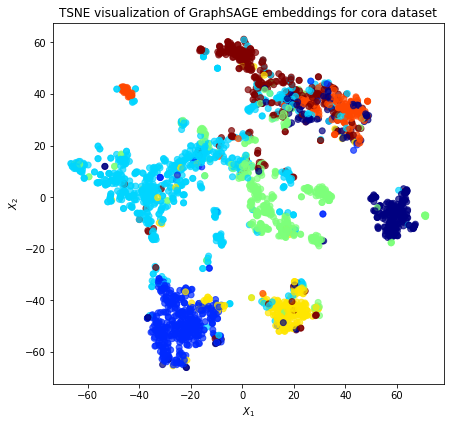

In [35]:
node_subject = node_subjects.astype("category").cat.codes

X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
    emb_transformed["label"] = node_subject
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = node_subject
    
    
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__)
)
plt.show()

In [24]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec, link_classification

from tensorflow import keras

from pandas.core.indexes.base import Index

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

from stellargraph import datasets
from IPython.display import display, HTML

In [21]:
nodes = list(G.nodes())
number_of_walks = 4
length = 5


unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes, length=length, number_of_walks=number_of_walks
)



In [22]:
batch_size = 50
epochs = 4

In [25]:
generator = Attri2VecLinkGenerator(G, batch_size)
train_gen = generator.flow(unsupervised_samples)

In [26]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [27]:
layer_sizes = [128]
attri2vec = Attri2Vec(
    layer_sizes=layer_sizes, generator=generator, bias=False, normalize=None
)

In [28]:
# Build the model and expose input and output sockets of attri2vec, for node pair inputs:
x_inp, x_out = attri2vec.in_out_tensors()



In [29]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)


link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [30]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

In [31]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=2,
    use_multiprocessing=False,
    workers=1,
    shuffle=True,
)

Epoch 1/4
1734/1734 - 4s - loss: 0.6970 - binary_accuracy: 0.5379
Epoch 2/4
1734/1734 - 4s - loss: 0.6358 - binary_accuracy: 0.6292
Epoch 3/4
1734/1734 - 4s - loss: 0.4934 - binary_accuracy: 0.7790
Epoch 4/4
1734/1734 - 4s - loss: 0.3905 - binary_accuracy: 0.8404


In [32]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)


In [36]:
node_gen = Attri2VecNodeGenerator(G, batch_size).flow(subjects.index)
node_embeddings = embedding_model.predict(node_gen, workers=1, verbose=1)



50/50 [==============================] - 0s 749us/step


In [37]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

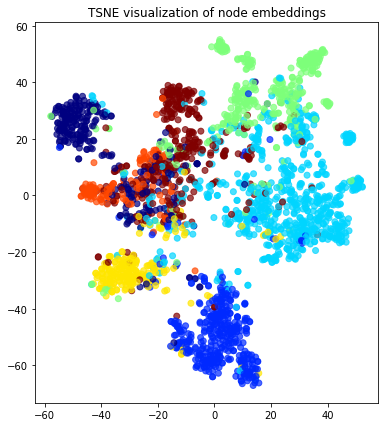

In [38]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(subjects))}
node_colours = [label_map[target] for target in subjects]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()



In [85]:
df = pd.read_csv("flask_app/flaskr/static/opensea_cluster_output_oct29.csv")


In [92]:
df

Id  cluster_exp0  cluster_exp1  \
0     0x906e55e1035c8a0828f249c173d8090e8fd5f189           4.0           1.0   
1     0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7           0.0           6.0   
2     0x0a4eafeb533d4111a1fe3a8b323c468976ac2323           4.0           1.0   
3      0xa4eafeb533d4111a1fe3a8b323c468976ac2323           4.0          24.0   
4       0xd7c902fbbcd3c9db2da80a439c94486c50eb81           2.0          24.0   
...                                          ...           ...           ...   
5119  0x8bfe24fb29f57a6fe885884963549d905dc035f2           4.0           1.0   
5120  0x9179de43eafb051053f4ab99b9d9292d20eea723           4.0           1.0   
5121  0x3945476e477de76d53b4833a46c806ef3d72b21e           4.0           1.0   
5122  0xe08c32737c021c7d05d116b00a68a02f2d144ac0           4.0           1.0   
5123                                         NaN           4.0           1.0   

      cluster_exp2  cluster_exp3  cluster_exp4  cluster_exp5  cluster_exp6  \
0             32.0          16.0          16.0           3.0           3.0   
1             11.0          12.0          23.0           0.0          13.0   
2             32.0          62.0          16.0           3.0           8.0   
3             30.0          16.0          76.0           3.0           8.0   
4             14.0          62.0          42.0           3.0           8.0   
...            ...           ...           ...           ...           ...   
5119          30.0          16.0          62.0           3.0           0.0   
5120          30.0          16.0          62.0           3.0           0.0   
5121          30.0          16.0          62.0           3.0           0.0   
5122          30.0          16.0          62.0           3.0           0.0   
5123          30.0          16.0          62.0           3.0           0.0   

      cluster_exp7  cluster_exp8  ...  cluster_exp91  cluster_exp92  \
0             14.0          29.0  ...            0.0           -1.0   
1             27.0          55.0  ...           -1.0           -1.0   
2              3.0          11.0  ...           -1.0           -1.0   
3              7.0           3.0  ...           -1.0           -1.0   
4              7.0           3.0  ...           -1.0           -1.0   
...            ...           ...  ...            ...            ...   
5119           0.0          10.0  ...           -1.0           -1.0   
5120           0.0          10.0  ...           -1.0           -1.0   
5121           0.0          10.0  ...           -1.0           -1.0   
5122           0.0          10.0  ...           -1.0           -1.0   
5123           0.0          10.0  ...           -1.0           -1.0   

      cluster_exp93  cluster_exp98  cluster_exp99  cluster_exp100  \
0              -1.0            0.0            0.0             0.0   
1              -1.0            0.0            0.0             0.0   
2              -1.0            1.0            1.0             0.0   
3              -1.0            1.0            2.0             0.0   
4              -1.0            1.0            2.0             0.0   
...             ...            ...            ...             ...   
5119           -1.0           18.0          341.0             0.0   
5120           -1.0           14.0           60.0             0.0   
5121           -1.0           14.0           60.0             0.0   
5122           -1.0            1.0           10.0             0.0   
5123           -1.0          359.0          825.0           307.0   

      cluster_exp101  cluster_exp102  cluster_exp103  cluster_exp104  
0                0.0             0.0             0.0             0.0  
1                0.0             1.0             0.0             0.0  
2              292.0             2.0             1.0             0.0  
3              292.0             3.0             1.0             1.0  
4              292.0             4.0             1.0             1.0  
...              ...             ...    

In [102]:
temp = df[['Id', 'cluster_exp1']].groupby('cluster_exp1').count().reset_index()
temp.columns = ['cluster', 'id']
temp.to_dict('records')

[{'cluster': 0.0, 'id': 1},
 {'cluster': 1.0, 'id': 4617},
 {'cluster': 2.0, 'id': 1},
 {'cluster': 3.0, 'id': 1},
 {'cluster': 4.0, 'id': 1},
 {'cluster': 5.0, 'id': 1},
 {'cluster': 6.0, 'id': 1},
 {'cluster': 7.0, 'id': 1},
 {'cluster': 8.0, 'id': 1},
 {'cluster': 9.0, 'id': 1},
 {'cluster': 10.0, 'id': 1},
 {'cluster': 11.0, 'id': 1},
 {'cluster': 12.0, 'id': 1},
 {'cluster': 13.0, 'id': 1},
 {'cluster': 14.0, 'id': 1},
 {'cluster': 15.0, 'id': 1},
 {'cluster': 16.0, 'id': 1},
 {'cluster': 17.0, 'id': 105},
 {'cluster': 18.0, 'id': 1},
 {'cluster': 19.0, 'id': 273},
 {'cluster': 20.0, 'id': 1},
 {'cluster': 21.0, 'id': 1},
 {'cluster': 22.0, 'id': 1},
 {'cluster': 23.0, 'id': 1},
 {'cluster': 24.0, 'id': 107}]

In [14]:
fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)
gcn_model = GCN(layer_sizes=[128], activations=["relu"], generator=fullbatch_generator)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())

Using GCN (local pooling) filters...


In [15]:
def run_deep_graph_infomax(
    base_model, generator, epochs, reorder=lambda sequence, subjects: subjects
):
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes())
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    # for full batch models, squeeze out the batch dim (which is 1)
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

    test_gen = generator.flow(test_subjects.index)
    train_gen = generator.flow(train_subjects.index)

    test_embeddings = emb_model.predict(test_gen)
    train_embeddings = emb_model.predict(train_gen)

    # some generators yield predictions in a different order to the .flow argument,
    # so we need to get everything lined up correctly
    ordered_test_subjects = reorder(test_gen, test_subjects)
    ordered_train_subjects = reorder(train_gen, train_subjects)

    lr = LogisticRegression(multi_class="auto", solver="lbfgs")
    lr.fit(train_embeddings, ordered_train_subjects)

    y_pred = lr.predict(test_embeddings)
    acc = (y_pred == ordered_test_subjects).mean()

    return acc

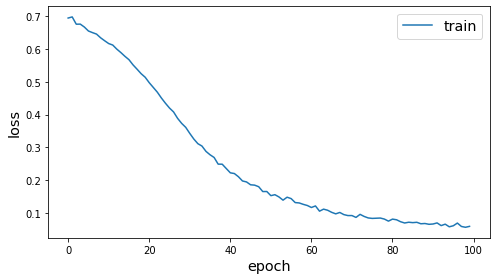

In [16]:
infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))

epochs=100
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
plot_history(history)

In [17]:
cluster_generator = ClusterNodeGenerator(stellarG, clusters=12, q=4)
cluster_gcn_model = GCN(
    layer_sizes=[128], activations=["relu"], generator=cluster_generator
)


def cluster_reorder(sequence, subjects):
    # shuffle the subjects into the same order as the sequence yield
    return subjects[sequence.node_order]


cluster_gcn_acc = run_deep_graph_infomax(
    cluster_gcn_model, cluster_generator, epochs=epochs, reorder=cluster_reorder
)
print(f"Test classification accuracy: {cluster_gcn_acc}")


Number of clusters 12
0 cluster has size 225
1 cluster has size 225
2 cluster has size 225
3 cluster has size 225
4 cluster has size 225
5 cluster has size 225
6 cluster has size 225
7 cluster has size 225
8 cluster has size 225
9 cluster has size 225
10 cluster has size 225
11 cluster has size 233


NameError: name 'test_subjects' is not defined

In [49]:
gat_model = GAT(
    layer_sizes=[128], activations=["relu"], generator=fullbatch_generator, attn_heads=8,
)
gat_acc = run_deep_graph_infomax(gat_model, fullbatch_generator, epochs=epochs)

gat_acc
print(f"Test classification accuracy: {gat_acc}")

KeyError: array(['0x906e55e1035c8a0828f249c173d8090e8fd5f189',
       '0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7',
       '0x0a4eafeb533d4111a1fe3a8b323c468976ac2323', ...,
       '0x3945476e477de76d53b4833a46c806ef3d72b21e',
       '0xe08c32737c021c7d05d116b00a68a02f2d144ac0', 'nan'], dtype='<U42')

In [50]:
appnp_model = APPNP(
    layer_sizes=[128], activations=["relu"], generator=fullbatch_generator
)
appnp_acc = run_deep_graph_infomax(appnp_model, fullbatch_generator, epochs=epochs)

print(f"Test classification accuracy: {appnp_acc}")

KeyError: array(['0x906e55e1035c8a0828f249c173d8090e8fd5f189',
       '0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7',
       '0x0a4eafeb533d4111a1fe3a8b323c468976ac2323', ...,
       '0x3945476e477de76d53b4833a46c806ef3d72b21e',
       '0xe08c32737c021c7d05d116b00a68a02f2d144ac0', 'nan'], dtype='<U42')

In [51]:
graphsage_generator = GraphSAGENodeGenerator(stellarG, batch_size=1000, num_samples=[5])

graphsage_model = GraphSAGE(
    layer_sizes=[128], activations=["relu"], generator=graphsage_generator
)
graphsage_acc = run_deep_graph_infomax(
    graphsage_model, graphsage_generator, epochs=epochs
)

print(f"Test classification accuracy: {graphsage_acc}")

RuntimeError: This StellarGraph has no numeric feature attributes for nodesNode features are required for machine learning

In [15]:
dataset = datasets.Cora()

In [16]:
display(HTML(dataset.description))

In [35]:
G, subjects = dataset.load(largest_connected_component_only=True)

In [32]:
cluster_generator = ClusterNodeGenerator(G, clusters=12, q=4)
cluster_gcn_model = GCN(
    layer_sizes=[128], activations=["relu"], generator=cluster_generator
)


def cluster_reorder(sequence, subjects):
    # shuffle the subjects into the same order as the sequence yield
    return subjects[sequence.node_order]


cluster_gcn_acc = run_deep_graph_infomax(
    cluster_gcn_model, cluster_generator, epochs=epochs, reorder=cluster_reorder
)
print(f"Test classification accuracy: {cluster_gcn_acc}")


Number of clusters 12
0 cluster has size 225
1 cluster has size 225
2 cluster has size 225
3 cluster has size 225
4 cluster has size 225
5 cluster has size 225
6 cluster has size 225
7 cluster has size 225
8 cluster has size 225
9 cluster has size 225
10 cluster has size 225
11 cluster has size 233
Test classification accuracy: 0.6579163248564397


In [18]:
fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)
gcn_model = GCN(layer_sizes=[128], activations=["relu"], generator=fullbatch_generator)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())

Using GCN (local pooling) filters...


In [19]:
infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))


In [21]:
epochs = 100

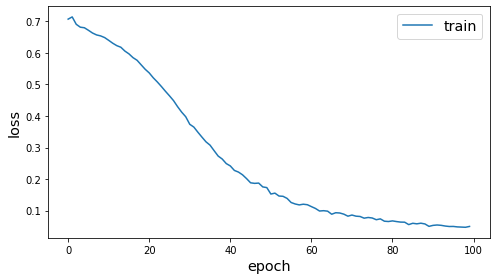

In [22]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
plot_history(history)

In [24]:
G.node_features()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
G.nodes()

Int64Index([  31336, 1061127, 1106406,   13195,   37879, 1126012, 1107140,
            1102850,   31349, 1106418,
            ...
             626531, 1131180, 1130454, 1131184, 1128974, 1128975, 1128977,
            1128978,  117328,   24043],
           dtype='int64', length=2708)

In [27]:
x_emb_in, x_emb_out = gcn_model.in_out_tensors()

# for full batch models, squeeze out the batch dim (which is 1)
x_out = tf.squeeze(x_emb_out, axis=0)
emb_model = Model(inputs=x_emb_in, outputs=x_out)

In [28]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

test_gen = fullbatch_generator.flow(test_subjects.index)
train_gen = fullbatch_generator.flow(train_subjects.index)

test_embeddings = emb_model.predict(test_gen)
train_embeddings = emb_model.predict(train_gen)

lr = LogisticRegression(multi_class="auto", solver="lbfgs")
lr.fit(train_embeddings, train_subjects)

y_pred = lr.predict(test_embeddings)
gcn_acc = (y_pred == test_subjects).mean()
print(f"Test classification accuracy: {gcn_acc}")

Test classification accuracy: 0.8022969647251845


In [29]:
all_embeddings = emb_model.predict(fullbatch_generator.flow(G.nodes()))

y = node_subjects.astype("category")
trans = TSNE(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=G.nodes())
emb_transformed["label"] = y

KeyboardInterrupt: 

In [ ]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].cat.codes,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title("TSNE visualization of GCN embeddings for cora dataset")
plt.show()

In [147]:
wallet_of_interest = output.loc[output['cluster'] == random_cluster, :].index.tolist()
edge_df.loc[(edge_df['WinnerAddress'].isin(wallet_of_interest))|(edge_df['SellerAddress'].isin(wallet_of_interest))]

SellerAddress  \
17994   0x9b35dbc596f545739e25e203b41823251acdee17   
32431   0x9b35dbc596f545739e25e203b41823251acdee17   
71084   0x9b35dbc596f545739e25e203b41823251acdee17   
79819   0x9b35dbc596f545739e25e203b41823251acdee17   
82404   0x9b35dbc596f545739e25e203b41823251acdee17   
95675   0x9b35dbc596f545739e25e203b41823251acdee17   
111041  0xa1b2c179955310fa41e561661d2c3f1ca90b1e36   
147717  0xeee5eb24e7a0ea53b75a1b9ad72e7d20562f4283   
148909  0x9b35dbc596f545739e25e203b41823251acdee17   
155873  0x9b35dbc596f545739e25e203b41823251acdee17   
155878  0xa1b2c179955310fa41e561661d2c3f1ca90b1e36   
156142  0xb1a8757c8d71f5ef878d56a1fb045c592a7ef6e4   
156144  0xa1b2c179955310fa41e561661d2c3f1ca90b1e36   
160272  0xa1b2c179955310fa41e561661d2c3f1ca90b1e36   
166139  0x9b35dbc596f545739e25e203b41823251acdee17   

                                     WinnerAddress            Timestamp  \
17994   0x53ede7cae3eb6a7d11429fe589c0278c9acbe21a  2020-08-26T11:31:41   
32431   0x53ede7cae3eb6a7d11429fe589c0278c9acbe21a  2020-08-26T12:03:46   
71084   0x53ede7cae3eb6a7d11429fe589c0278c9acbe21a  2020-08-26T11:01:49   
79819   0x53ede7cae3eb6a7d11429fe589c0278c9acbe21a  2020-08-26T12:03:49   
82404   0x53ede7cae3eb6a7d11429fe589c0278c9acbe21a  2020-08-28T11:57:51   
95675   0x1d1ef89654fe251fef926a721c5a393dfc50b489  2020-11-17T12:21:50   
111041                                         NaN  2019-09-17T05:52:00   
147717  0x9b35dbc596f545739e25e203b41823251acdee17  2020-12-21T19:18:53   
148909  0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459  2020-08-30T10:43:23   
155873  0xa1b2c179955310fa41e561661d2c3f1ca90b1e36  2020-10-24T01:34:24   
155878                                         NaN  2019-09-17T05:46:33   
156142  0xa1b2c179955310fa41e561661d2c3f1ca90b1e36  2021-02-17T22:07:45   
156144                                         NaN  2019-09-17T06:03:10   
160272                                         NaN  2019-09-17T05:55:28   
166139   0xa4eafeb533d4111a1fe3a8b323c468976ac2323  2020-09-13T22:06:44   

         EventType PaymenTokenSymbol            TotalPrice  TokenId  \
17994   successful               ETH   1100000000000000000     9182   
32431   successful               ETH   1100000000000000000     8308   
71084   successful               ETH   1100000000000000000     6259   
79819   successful               ETH   1400000000000000000     5769   
82404   successful               ETH   1100000000000000000     5620   
95675   successful               ETH  11000000000000000000     4851   
111041  successful               ETH    450000000000000000     3906   
147717  successful               ETH   3700000000000000000     1904   
148909  successful               ETH   1200000000000000000     1841   
155873  successful               ETH   5300000000000000000     1416   
155878  successful               ETH    400000000000000000     1416   
156142  successful               ETH  10000000000000000000     1397   
156144  successful               ETH    300000000000000000     1397   
160272  successful               ETH    450000000000000000     1045   
166139  successful               ETH   5500000000000000000      544   

                              AssetContractAddress  AssetId  TransactionId  \
17994   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   530625     42460607.0   
32431   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   530103     42464569.0   
71084   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   528837     42456169.0   
79819   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   528519     42464619.0   
82404   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   528430     42848564.0   
95675   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   178734     60574542.0   
111041  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   179336      9757908.0   
147717  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   179619     68433082.0   
148909  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   176547     43258165.0   
155873  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   1

In [106]:
output.head()

0  cluster
0x000000000cc7e508b4b115e64d71ef374cfb7703   {'c_infomap': 65}       65
0x000000aaee6a496aaf7b7452518781786313400f  {'c_infomap': 547}      547
0x0006e4548aed4502ec8c844567840ce6ef1013f5  {'c_infomap': 317}      317
0x00084121aec4309cb20db622a28c717720e888e0  {'c_infomap': 389}      389
0x000e8c608473dcee93021eb1d39fb4a7d7e7d780  {'c_infomap': 431}      431

In [78]:

Gs = sg.StellarGraph.from_networkx(G)
print(Gs.info())



StellarGraph: Undirected multigraph
 Nodes: 4912, Edges: 12226

 Node types:
  default: [4912]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [12226]
        Weights: all 1 (default)
        Features: none


In [79]:
# parameter specification
number_of_walks = 3
length = 5
batch_size = 50
epochs = 10
num_samples = [20, 20]
layer_sizes = [100, 100]
learning_rate = 1e-2

In [80]:
unsupervisedSamples = UnsupervisedSampler(
    Gs, nodes=G.nodes(), length=length, number_of_walks=number_of_walks
)

In [81]:
generator = GraphSAGELinkGenerator(Gs, batch_size, num_samples)
train_gen = generator.flow(unsupervisedSamples)

RuntimeError: This StellarGraph has no numeric feature attributes for nodesNode features are required for machine learning